# Spatiotemporal Wave Height Prediction using ConvLSTM Network

This notebook implements an end-to-end deep learning pipeline to predict spectral significant wave height (VHM0) using the Copernicus Marine dataset.

**Objective:** Predict VHM0 using spatiotemporal patterns in oceanographic data  
**Model:** ConvLSTM for capturing both spatial and temporal dependencies

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import os
import time

warnings.filterwarnings('ignore')
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.5.1


In [5]:
# Set up the GPU device (This is crucial for GPU training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: ohh yeh!! {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Using device: cuda
Number of available GPUs: ohh yeh!! 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti


## Step 1: Data Loading & Initial Exploration

In [3]:
# Load the NetCDF dataset
# Use a raw string (r"...") for Windows paths and add the .nc extension
data_path = r'D:\babe_prediction\cmems_mod_ibi_wav_anfc_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.97N_2022-12-01-2025-01-01-001.nc'
try:
    # Explicitly tell xarray to use the 'netcdf4' engine
    ds = xr.open_dataset(data_path, engine="netcdf4")
    print("Dataset loaded successfully!")
    print("\nDataset Overview:")
    print(f"Dimensions: {dict(ds.dims)}")
    print(f"Coordinates: {list(ds.coords)}")
    print(f"Data variables: {list(ds.data_vars)}")

except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"Dataset not found at the path: {data_path}")
    print("Please make sure the .nc file is in the same folder as your notebook.")

Dataset loaded successfully!

Dataset Overview:
Dimensions: {'time': 18289, 'latitude': 90, 'longitude': 90}
Coordinates: ['latitude', 'longitude', 'time']
Data variables: ['VCMX', 'VHM0', 'VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED', 'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK']


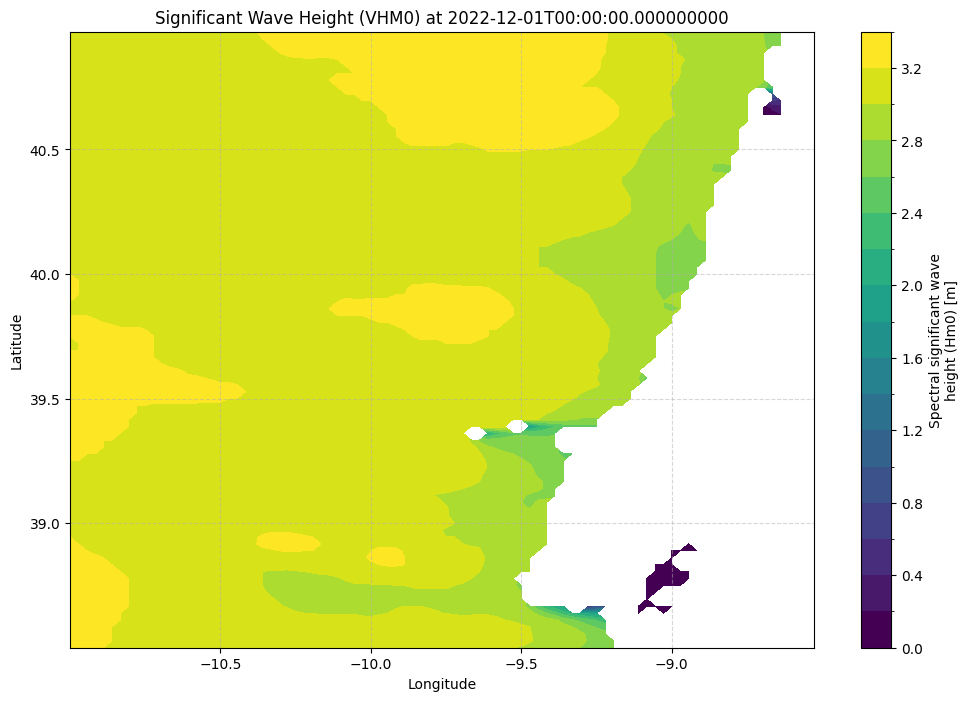

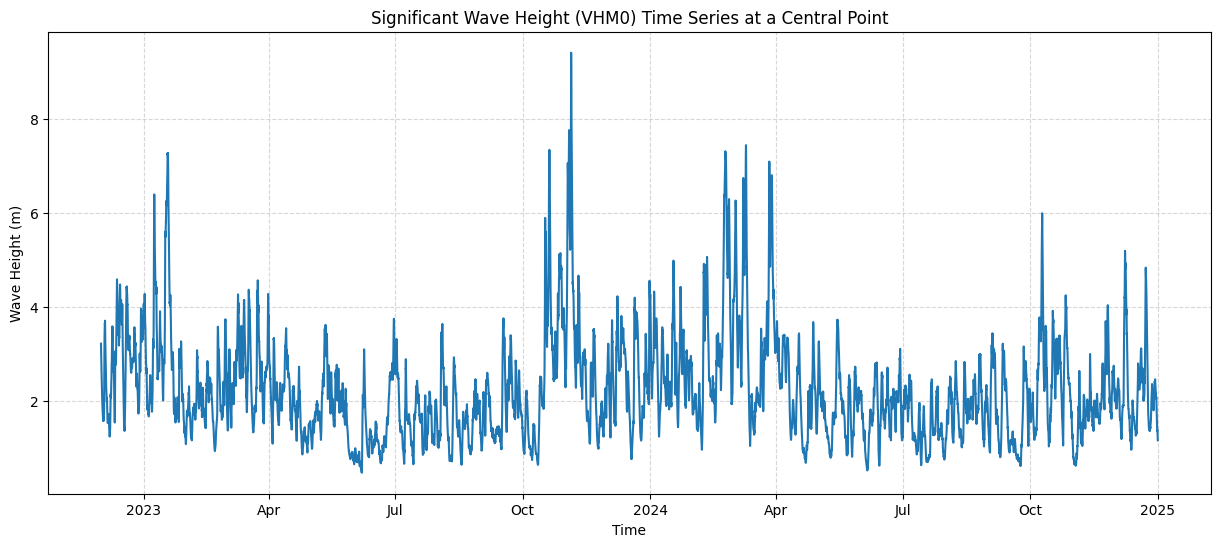

In [4]:
# This visualization uses the raw, unprocessed data from the loaded dataset

# --- 1. Spatial Map Visualization ---
plt.figure(figsize=(12, 8))
# Select the VHM0 variable at the very first time step (time=0)
first_step = ds['VHM0'].isel(time=0)

# Create a contour plot
first_step.plot.contourf(x='longitude', y='latitude', cmap='viridis', levels=20)

plt.title(f"Significant Wave Height (VHM0) at {first_step.time.values}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# --- 2. Time Series Visualization ---
plt.figure(figsize=(15, 6))

# Select a central latitude and longitude point for the time series
central_point = ds['VHM0'].sel(
    latitude=ds.latitude.values[len(ds.latitude)//2],
    longitude=ds.longitude.values[len(ds.longitude)//2],
    method='nearest'
)

# Plot the time series for the selected point
central_point.plot()

plt.title("Significant Wave Height (VHM0) Time Series at a Central Point")
plt.ylabel("Wave Height (m)")
plt.xlabel("Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Step 2: Data Preprocessing

In [5]:
# Define target and feature variables
target_var = 'VHM0'
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR', 'VTPK', 'VSDX', 'VSDY']

# Handle circular features (wave directions)
print("Processing circular features...")
ds_processed = ds.copy()
radians = np.deg2rad(ds_processed['VMDR'])
ds_processed['VMDR_sin'] = np.sin(radians)
ds_processed['VMDR_cos'] = np.cos(radians)
ds_processed = ds_processed.drop_vars(['VMDR'])

# Update feature variables list
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']
all_vars_to_process = [target_var] + feature_vars
print(f"Updated feature variables: {feature_vars}")

Processing circular features...
Updated feature variables: ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']


In [6]:
# --- Reduce memory usage by converting to float32 ---
print(f"\nOriginal memory usage: {ds_processed.nbytes / 1e9:.2f} GB")
for var in ds_processed.data_vars:
    if ds_processed[var].dtype == 'float64':
        ds_processed[var] = ds_processed[var].astype('float32')
print(f"New memory usage after float32 conversion: {ds_processed.nbytes / 1e9:.2f} GB")

# --- Fill NaN values (land mask) with 0 ---
ds_filled = ds_processed.fillna(0)
print("\nFilled NaN values with 0.")

# --- Scale the data ---
print("\nScaling data...")
ds_scaled = ds_filled.copy()
scalers = {}

for var in all_vars_to_process:
    var_scaler = MinMaxScaler()
    var_data = ds_filled[var].values
    
    # Reshape for scaling: (time, lat*lon)
    original_shape = var_data.shape
    var_data_2d = var_data.reshape(original_shape[0], -1)
    
    # Fit and transform
    var_scaled_2d = var_scaler.fit_transform(var_data_2d)
    
    # Reshape back and update dataset
    ds_scaled[var] = (ds_filled[var].dims, var_scaled_2d.reshape(original_shape))
    scalers[var] = var_scaler
    print(f"  - Scaled {var}")

print("Data scaling completed!")


Original memory usage: 23.70 GB
New memory usage after float32 conversion: 11.85 GB

Filled NaN values with 0.

Scaling data...
  - Scaled VHM0
  - Scaled VHM0_SW1
  - Scaled VHM0_SW2
  - Scaled VHM0_WW
  - Scaled VMDR_sin
  - Scaled VMDR_cos
  - Scaled VTPK
  - Scaled VSDX
  - Scaled VSDY
Data scaling completed!


## Step 3: Create PyTorch Dataset and DataLoaders
This replaces the Keras Sequence Generator to efficiently handle the large dataset for PyTorch.

In [11]:
# --- NEW: Lazy-Loading PyTorch Dataset ---
# This class reads data in small chunks directly from the disk, preventing RAM overflow.

class WaveDataset_Lazy(Dataset):
    """
    Custom PyTorch Dataset for on-the-fly batch generation by reading
    data chunks directly from the NetCDF file.
    """
    def __init__(self, data_path, feature_vars, target_var, indices, scalers, lookback=24):
        self.data_path = data_path
        self.feature_vars = feature_vars
        self.target_var = target_var
        self.indices = indices
        self.lookback = lookback
        self.scalers = scalers
        self.all_vars = [self.target_var] + self.feature_vars

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        seq_start_idx = self.indices[idx]
        seq_end_idx = seq_start_idx + self.lookback
        target_idx = seq_end_idx

        # Open the dataset, get the required slice, and close it immediately
        with xr.open_dataset(self.data_path) as ds:
            data_slice = ds[self.all_vars].isel(time=slice(seq_start_idx, target_idx + 1))

        # --- Preprocess this small chunk on-the-fly ---
        # 1. Fill NaNs
        data_slice = data_slice.fillna(0)

        # 2. Handle circular features
        radians = np.deg2rad(data_slice['VMDR'])
        data_slice['VMDR_sin'] = (('time', 'latitude', 'longitude'), np.sin(radians).astype(np.float32))
        data_slice['VMDR_cos'] = (('time', 'latitude', 'longitude'), np.cos(radians).astype(np.float32))
        
        # 3. Scale the data using the pre-fitted scalers
        for var in self.all_vars:
            if var in self.scalers: # Skip VMDR which is now sin/cos
                scaler = self.scalers[var]
                var_data = data_slice[var].values
                original_shape = var_data.shape
                var_data_2d = var_data.reshape(original_shape[0], -1)
                var_scaled_2d = scaler.transform(var_data_2d) # Use transform, not fit_transform
                data_slice[var] = (data_slice[var].dims, var_scaled_2d.reshape(original_shape))

        # 4. Create final X and y tensors
        features_list = [data_slice[var].isel(time=slice(0, self.lookback)).values for var in self.feature_vars]
        X = np.stack(features_list, axis=0).astype(np.float32)
        y = data_slice[self.target_var].isel(time=self.lookback).values.astype(np.float32) # last time step is target
        
        # Permute to PyTorch format: (timesteps, features, lat, lon)
        X = X.transpose(1, 0, 2, 3)
        y = np.expand_dims(y, axis=0) # Add channel dimension
        
        return torch.from_numpy(X), torch.from_numpy(y)

In [14]:
# --- Define parameters and perform the chronological data split ---
lookback_hours = 24
batch_size = 8 # This is a good starting point for your dual 1080 Ti setup

n_time = ds.dims['time'] # Use the original dataset 'ds' for dimension length
n_sequences = n_time - lookback_hours
all_indices = np.arange(n_sequences)

# Chronological split (70% train, 15% validation, 15% test)
train_end = int(n_sequences * 0.7)
val_end = int(n_sequences * 0.85)

train_indices = all_indices[:train_end]
val_indices = all_indices[train_end:val_end]
test_indices = all_indices[val_end:]

print(f"Total sequences: {n_sequences}")
print(f"Training indices count: {len(train_indices)}")
print(f"Validation indices count: {len(val_indices)}")
print(f"Test indices count: {len(test_indices)}")


# --- Update your feature_vars list ---
feature_vars = ['VHM0_SW1', 'VHM0_SW2', 'VHM0_WW', 'VMDR_sin', 'VMDR_cos', 'VTPK', 'VSDX', 'VSDY']

# --- Now, instantiate the LAZY Datasets and DataLoaders ---
train_dataset = WaveDataset_Lazy(data_path, feature_vars, target_var, train_indices, scalers, lookback=lookback_hours)
val_dataset = WaveDataset_Lazy(data_path, feature_vars, target_var, val_indices, scalers, lookback=lookback_hours)
test_dataset = WaveDataset_Lazy(data_path, feature_vars, target_var, test_indices, scalers, lookback=lookback_hours)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("\nPyTorch LAZY DataLoaders created successfully!")
print("Memory usage will now be minimal, as data is loaded in chunks during training.")

Total sequences: 18265
Training indices count: 12785
Validation indices count: 2740
Test indices count: 2740

PyTorch LAZY DataLoaders created successfully!
Memory usage will now be minimal, as data is loaded in chunks during training.


## Step 4: Build the ConvLSTM Model in PyTorch

In [15]:
import torch
import torch.nn as nn

class ConvLSTM2dCell(nn.Module):
    """A single ConvLSTM cell."""
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTM2dCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # A single convolution for all gates (input, forget, output, cell)
        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM2d(nn.Module):
    """The full ConvLSTM layer that iterates over the time sequence."""
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers=1,
                 batch_first=True, bias=True, padding='same'): # Added padding for compatibility
        super(ConvLSTM2d, self).__init__()
        self.kernel_size = self._check_kernel_size_consistency(kernel_size)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias

        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim
            cell_list.append(ConvLSTM2dCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim,
                                          kernel_size=self.kernel_size,
                                          bias=self.bias))
        
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        if self.batch_first:
            b, seq_len, _, h, w = input_tensor.size()
        else:
            seq_len, b, _, h, w = input_tensor.size()

        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        last_state_list = []
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)
            
            layer_output = torch.stack(output_inner, dim=1)
            last_state_list.append([h, c])

        # We only need the last state of the final layer
        return layer_output, last_state_list[-1]

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not isinstance(kernel_size, tuple) and not (isinstance(kernel_size, list) and len(kernel_size) == 2):
             return (kernel_size, kernel_size)
        return kernel_size

In [2]:
class ConvLSTMNet(nn.Module):
    def __init__(self, input_channels, hidden_channels=[64, 32], kernel_size=(3, 3), dropout_rate=0.2):
        super(ConvLSTMNet, self).__init__()
        
        self.convlstm1 = ConvLSTM2d(
            input_dim=input_channels,
            hidden_dim=hidden_channels[0],
            kernel_size=kernel_size,
            num_layers=1,
            batch_first=True,
            padding='same'
        )
        self.batchnorm1 = nn.BatchNorm3d(hidden_channels[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.convlstm2 = ConvLSTM2d(
            input_dim=hidden_channels[0],
            hidden_dim=hidden_channels[1],
            kernel_size=kernel_size,
            num_layers=1,
            batch_first=True,
            padding='same'
        )
        self.batchnorm2 = nn.BatchNorm3d(hidden_channels[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output convolution
        self.conv_out = nn.Conv2d(
            in_channels=hidden_channels[1],
            out_channels=1,
            kernel_size=(1, 1),
            padding='same'
        )

    def forward(self, x):
        _, (h1, _) = self.convlstm1(x)
        x = h1[0]
        x = x.unsqueeze(1)
        _, (h2, _) = self.convlstm2(x)
        x = h2[0]
        output = self.conv_out(x)
        return output

# --- Instantiate the model and move it to the GPU ---
input_channels = len(feature_vars)
model = ConvLSTMNet(input_channels=input_channels)

# NEW: Check for multiple GPUs and wrap the model with DataParallel
if torch.cuda.device_count() > 1:
  print(f"Let's use {torch.cuda.device_count()} GPUs!")
  model = nn.DataParallel(model)

# Move the model to the primary GPU device
model.to(device)

print("PyTorch model built and enabled for multi-GPU.")
print(model)

NameError: name 'feature_vars' is not defined

## Step 5: Compile and Train the Model

In [19]:
# --- Custom Weighted MSE Loss in PyTorch ---
def weighted_mse_loss(output, target, weight_threshold=0.8):
    mse = (output - target) ** 2
    weights = torch.where(target > weight_threshold, 2.0, 1.0)
    weighted_mse = weights * mse
    return torch.mean(weighted_mse)

loss_function = weighted_mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Optimizer and Loss Function defined.")

Optimizer and Loss Function defined.


In [3]:
import torch
import torch.nn as nn
import time

# 1. Setup Device and check for GPUs
if not torch.cuda.is_available():
    print("CUDA is not available. This test requires GPUs.")
else:
    device = torch.device("cuda")
    print(f"CUDA is available! Using {torch.cuda.device_count()} GPUs.")

    # 2. Define a very simple CNN model
    class SimpleTestNet(nn.Module):
        def __init__(self):
            super(SimpleTestNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.fc1 = nn.Linear(64 * 8 * 8, 10) # Assuming 32x32 input images

        def forward(self, x):
            x = torch.relu(self.conv1(x))
            x = torch.max_pool2d(x, 2)
            x = torch.relu(self.conv2(x))
            x = torch.max_pool2d(x, 2)
            x = x.view(x.size(0), -1) # Flatten
            x = self.fc1(x)
            return x

    # 3. Instantiate the model and wrap it for multi-GPU
    model = SimpleTestNet()
    if torch.cuda.device_count() > 1:
        print("Wrapping model with nn.DataParallel...")
        model = nn.DataParallel(model)
    model.to(device)

    # 4. Create random dummy data to train on
    batch_size = 256 # A larger batch size helps utilize the GPUs
    dummy_inputs = torch.randn(batch_size, 3, 32, 32).to(device)
    dummy_labels = torch.randint(0, 10, (batch_size,)).to(device)

    # 5. Simple training loop to make the GPUs work
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    print("\nStarting short training test... Watch your GPUs with nvidia-smi!")
    start_time = time.time()
    for i in range(20): # Run 20 quick steps
        optimizer.zero_grad()
        outputs = model(dummy_inputs)
        loss = loss_fn(outputs, dummy_labels)
        loss.backward()
        optimizer.step()
        if (i + 1) % 5 == 0:
            print(f"  Step {i+1}, Loss: {loss.item():.4f}")
    end_time = time.time()
    
    print(f"\nTest finished in {end_time - start_time:.2f} seconds. ✅")

CUDA is available! Using 2 GPUs.
Wrapping model with nn.DataParallel...

Starting short training test... Watch your GPUs with nvidia-smi!
  Step 5, Loss: 2.2863
  Step 10, Loss: 2.2730
  Step 15, Loss: 2.2601
  Step 20, Loss: 2.2472

Test finished in 0.36 seconds. ✅


In [4]:
# --- ADD THIS IMPORT AT THE TOP OF YOUR CELL ---
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau # NEW: Import the scheduler

# --- UPGRADED Training and Validation Loop ---
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, model_path='best_convlstm_model.pth'):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    # NEW: Initialize the GradScaler for mixed-precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # NEW: Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

    print("\n--- Starting model training with Mixed Precision and LR Scheduler ---")
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # --- Training Phase ---
        model.train()
        total_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        
        for X_batch, y_batch in train_pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # NEW: Use autocast for the forward pass (runs in float16)
            with torch.cuda.amp.autocast():
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            
            # NEW: Scale the loss and call backward and optimizer step via the scaler
            scaler.scale(loss).backward()
            
            # NEW: Add Gradient Clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            total_train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item(), 'lr': optimizer.param_groups[0]['lr']})
            
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
        
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_pbar:
                X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
                y_pred_val = model(X_batch_val)
                val_loss = loss_fn(y_pred_val, y_batch_val)
                total_val_loss += val_loss.item()
                val_pbar.set_postfix({'val_loss': val_loss.item()})

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        end_time = time.time()
        
        print(f"Epoch {epoch+1} Summary | "
              f"Avg Train Loss: {avg_train_loss:.6f} | "
              f"Avg Val Loss: {avg_val_loss:.6f} | "
              f"Time: {end_time - start_time:.2f}s")
        
        # NEW: Step the scheduler based on validation loss
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_to_save, model_path)
            print(f"  -> ✅ New best model saved to {model_path} (Val Loss: {best_val_loss:.6f})")
            
    print("\nTraining finished!")
    return model, history

# --- Start the Training ---
trained_model, history = train_model(model, train_loader, val_loader, optimizer, loss_function, epochs=5)

NameError: name 'train_loader' is not defined

## Step 6: Evaluation and Visualization

In [ ]:
print("--- Evaluating the trained model on the test set ---")

# Load the best performing model
model.load_state_dict(torch.load('best_convlstm_model.pth'))
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch_test, y_batch_test in test_loader:
        X_batch_test = X_batch_test.to(device)
        y_pred_test = model(X_batch_test)
        all_y_true.append(y_batch_test.cpu().numpy())
        all_y_pred.append(y_pred_test.cpu().numpy())

# Concatenate all batches
y_test_scaled = np.concatenate(all_y_true, axis=0).squeeze()
y_pred_scaled = np.concatenate(all_y_pred, axis=0).squeeze()

# --- Inverse transform predictions to original scale ---
print("\nInverse transforming predictions...")
target_scaler = scalers[target_var]
y_test_orig = target_scaler.inverse_transform(y_test_scaled.reshape(len(y_test_scaled), -1)).reshape(y_test_scaled.shape)
y_pred_orig = target_scaler.inverse_transform(y_pred_scaled.reshape(len(y_pred_scaled), -1)).reshape(y_pred_scaled.shape)

# --- Calculate metrics on original scale ---
test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig.flatten(), y_pred_orig.flatten()))
test_mae_orig = mean_absolute_error(y_test_orig.flatten(), y_pred_orig.flatten())

print(f"\nOriginal Scale Metrics on Test Set:")
print(f"  - RMSE: {test_rmse_orig:.4f} m")
print(f"  - MAE: {test_mae_orig:.4f} m")

In [ ]:
print("--- Visualizing a sample prediction from the test set ---")
# Pick a sample time step to visualize
time_idx_to_plot = 100 

true_map = y_test_orig[time_idx_to_plot]
predicted_map = y_pred_orig[time_idx_to_plot]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the true map
im1 = axes[0].imshow(true_map, cmap='viridis')
axes[0].set_title("True Wave Height Map (Ground Truth)")
plt.colorbar(im1, ax=axes[0], label='Wave Height (m)')

# Plot the predicted map
im2 = axes[1].imshow(predicted_map, cmap='viridis')
axes[1].set_title("Trained Model's Prediction")
plt.colorbar(im2, ax=axes[1], label='Wave Height (m)')

# Plot the error map
error_map = predicted_map - true_map
vmax = np.abs(error_map).max()
im3 = axes[2].imshow(error_map, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[2].set_title("Prediction Error (Pred - True)")
plt.colorbar(im3, ax=axes[2], label='Error (m)')

plt.tight_layout()
plt.show()

In [5]:
from netCDF4 import Dataset
all_ds = Dataset(r"D:\babe_prediction\cmems_mod_ibi_wav_my-aflux_0.027deg_P1H-i_TLA-TAUX-TAUY_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc")
print(all_ds.variables.keys())

dict_keys(['TLA', 'TAUX', 'TAUY', 'latitude', 'longitude', 'time'])


In [6]:
import xarray as xr
training_data_path = r'D:\babe_prediction\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc'

print(f"\n--- Loading training data from: {training_data_path} ---")
try:
    ds_train = xr.open_dataset(training_data_path, engine="netcdf4")
    print("Training dataset metadata loaded successfully!")
except FileNotFoundError:
    raise RuntimeError(f"Training data not found. Please check the path: {training_data_path}")



--- Loading training data from: D:\babe_prediction\cmems_mod_ibi_wav_my_0.027deg_PT1H-i_multi-vars_11.00W-8.53W_38.50N-40.47N_2020-01-01-2023-12-30.nc ---
Training dataset metadata loaded successfully!
